In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import BertForSequenceClassification, AdamW
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np

Мы будем работать с The Corpus of Linguistic Acceptability (CoLA) - датасетом для задачи бинарной классификации предложений. Он содержит набор предложений на русском языке с разметкой на 2 класса: грамматически корректные и грамматически некорректные.

In [ ]:
!git clone https://github.com/RussianNLP/RuCoLA.git

Cloning into 'RuCoLA'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 76 (delta 31), reused 52 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 948.93 KiB | 4.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
df = pd.read_csv('/content/RuCoLA/data/in_domain_train.csv', index_col= 'id').drop(['error_type', 'detailed_source'], axis = 1)
df.head()

,sentence,acceptable
id,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1
1,Этим летом не никуда ездили.,0
2,Только Иван выразил какую бы то ни было готовн...,1
3,"Теперь ты видишь собственными глазами, как тут...",1
4,На поверку вся теория оказалась полной чепухой.,1


In [ ]:
df['acceptable'].value_counts()

,count
acceptable,
1,5864
0,2005


In [ ]:
test_data = pd.read_csv('/content/RuCoLA/data/in_domain_dev.csv', index_col= 'id').drop(['error_type', 'detailed_source'], axis = 1)
test_data.head()

,sentence,acceptable
id,,
0,Иван вчера не позвонил.,1
1,"У многих туристов, кто посещают Кемер весной, ...",0
2,Лесные запахи набегали волнами; в них смешалос...,1
3,Вчера президент имел неофициальную беседу с ан...,1
4,Коллега так и не признал вину за катастрофу пе...,1


In [ ]:
test_data['acceptable'].value_counts()

,count
acceptable,
1,733
0,250


In [ ]:
test_data.shape

(983, 2)

In [ ]:
# df['error_type'].value_counts()

### Часть 1. BERT

Обучим BERT классифицировать наличие ошибок в предложении.

In [ ]:
# model_name = 'ai-forever/ruBert-large'
model_name = 'ai-forever/ruBert-base'

Чтобы подать на вход текст в BERT'а, его необходимо разбить на токены, а затем закодировать токены их порядковыми индексами в словаре.

Токенизировать предложения необходимо с помощью родного токенайзера модели, иначе может возникнуть путаница с индексами.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [ ]:
df.loc[0, 'sentence']

'Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.'

In [ ]:
# tokenizer.tokenize(df.loc[0, 'sentence'])

In [ ]:
# tokenizer.encode(df.loc[0, 'sentence'])

In [ ]:
# tokenizer.decode(tokenizer.encode(df.loc[0, 'sentence']))

In [ ]:
# tokenizer.convert_ids_to_tokens(tokenizer.encode(df.loc[0, 'sentence']))

In [ ]:
tokenizer(df.loc[0, 'sentence'])

{'input_ids': [101, 3014, 83321, 41548, 32350, 113, 2931, 121, 107, 660, 50354, 13779, 99183, 15226, 121, 94376, 19913, 700, 55918, 6412, 121, 107, 95640, 377, 104691, 717, 11420, 126, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
df['sentence_length'] = df['sentence'].map(lambda x: len(tokenizer.tokenize(x)))
df.head()

,sentence,acceptable,sentence_length
id,,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,27
1,Этим летом не никуда ездили.,0,6
2,Только Иван выразил какую бы то ни было готовн...,1,12
3,"Теперь ты видишь собственными глазами, как тут...",1,10
4,На поверку вся теория оказалась полной чепухой.,1,11


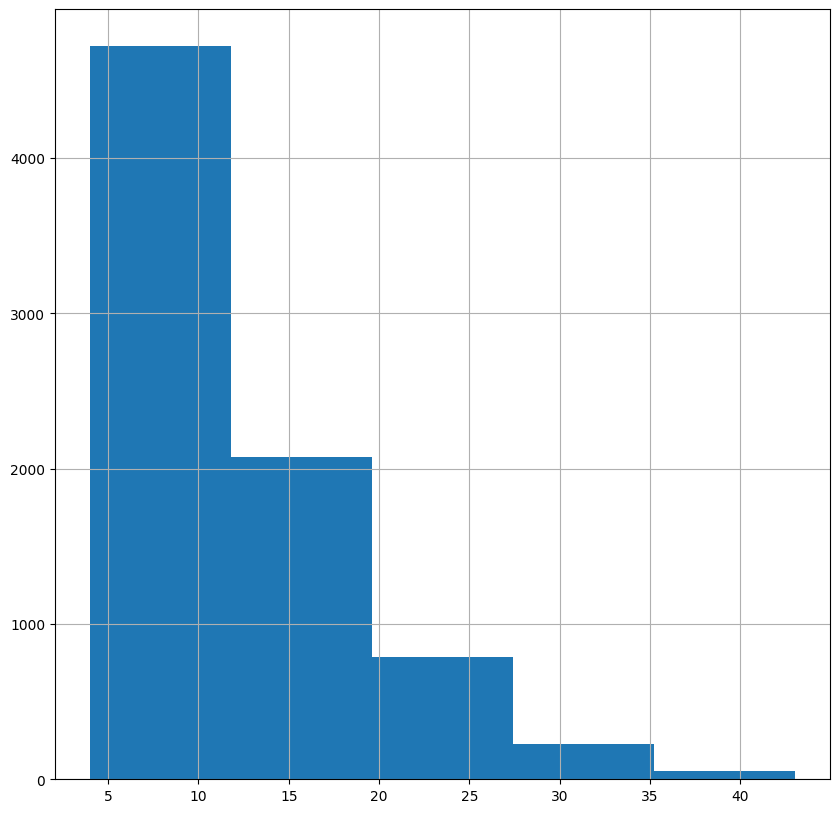

In [ ]:
plt.figure(figsize=(10,10))
df['sentence_length'].hist(bins = 5)
plt.show()

In [ ]:
# type(tokenizer)

#### Подготовка данных

Требования к форматированию текста

1. Добавить специальные токены начала и конца предложения.
2. Дополнить & усечь все предложения до одной длины.
3. В явном виде отделить реальные токены от padding-токенов с помощью "attention mask".


**`[SEP]`**

В конце каждого предложения необходимо добавить специальный токен `[SEP]`.

**`[CLS]`**

Для задач классификации в начале каждого предложения необходимо добавить токен `[CLS]`.

In [ ]:
tokenizer(text = df.loc[0, 'sentence'],
          padding = True,
          truncation = True,
          max_length = 25)

{'input_ids': [101, 3014, 83321, 41548, 32350, 113, 2931, 121, 107, 660, 50354, 13779, 99183, 15226, 121, 94376, 19913, 700, 55918, 6412, 121, 107, 95640, 377, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
df.loc[0, 'sentence']

'Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.'

In [ ]:
df.loc[1, 'sentence']

'Этим летом не никуда ездили.'

In [ ]:
tokenizer(text = df.loc[1, 'sentence'],
          padding = 'max_length',
          add_special_tokens = True,
          truncation = True,
          max_length = 25,
          return_tensors='pt')

{'input_ids': tensor([[  101,  2304,  7188,   672, 10510, 31598,   126,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [ ]:
split = 0.2

train_data_size = int(len(df) *(1 - split))

print('Train data size: ', train_data_size)
print('Validation data size: ', len(df) - train_data_size)

train_data = df.loc[:train_data_size, ['sentence', 'acceptable']]
val_data = df.loc[train_data_size:, ['sentence', 'acceptable']].reset_index(drop = True)

Train data size:  6295
Validation data size:  1574


In [ ]:
train_data.head()

,sentence,acceptable
id,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1
1,Этим летом не никуда ездили.,0
2,Только Иван выразил какую бы то ни было готовн...,1
3,"Теперь ты видишь собственными глазами, как тут...",1
4,На поверку вся теория оказалась полной чепухой.,1


In [ ]:
val_data.head()

,sentence,acceptable
0,Коллеги собирались арендовать клуб для проведе...,1
1,Он не пошел на работу.,1
2,Я стою прямо рядом с метро.,1
3,"Он почему-то решил то, что ему надо срочно беж...",0
4,"Пока ещё есть время понять, что от надёжности ...",0


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data, tokenizer, max_length = 25):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = 25

  def __len__(self):
    return len(self.data)


  def __getitem__(self, index):
    item = self.tokenizer(text = self.data.loc[index, 'sentence'],
                          padding = 'max_length',
                          add_special_tokens = True,
                          truncation = True,
                          max_length = self.max_length,
                          return_tensors='pt'
                          )

    # item['label'] = torch.tensor(np.array(self.data.loc[index, 'acceptable']))

    item['label'] = self.data.loc[index, 'acceptable']
    return item

In [ ]:
train_dataset = CustomDataset(data = train_data,
                              tokenizer = tokenizer
                             )

val_dataset = CustomDataset(data = val_data,
                              tokenizer = tokenizer
                            )

test_dataset = CustomDataset(data = test_data,
                              tokenizer = tokenizer
                            )

len(train_dataset), len(val_dataset), len(test_dataset)

(6296, 1574, 983)

In [ ]:
train_dataset[0]

{'input_ids': tensor([[  101,  3014, 83321, 41548, 32350,   113,  2931,   121,   107,   660,
         50354, 13779, 99183, 15226,   121, 94376, 19913,   700, 55918,  6412,
           121,   107, 95640,   377,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), 'label': 1}

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(val_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

In [ ]:
# list(train_loader)[0]

#### Инициализация модели для классификации

Предложения в датасете имеют разную длину. Как же BERT решает эту проблему?

У BERT'а есть 2 ограничения на входные предложения:
1. Все предложения должны иметь одинаковую фиксированную длину.
2. Максимальная допустимая длина предложений 512 токенов.

Для паддинга используется специальный токен `[PAD]` с индексом 0 в словаре BERT'а.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

"Attention Mask" это просто список из 0 и 1, указывающих, какие токены являются PAD-токенами, а какие нет. Эта маска помогает BERT'у  не учитывать PAD-токены при интерпретации предложения.

Также стоит отметить, что максимальная длина предложений влияет на скорость обучения.
Пример для Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [ ]:
type(model)

transformers.models.bert.modeling_bert.BertForSequenceClassification

In [ ]:
class BertClassifier(torch.nn.Module):
  def __init__(self, model_name = model_name):
    super(BertClassifier, self).__init__()
    self.model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = model_name)

    # Замораживаем все параметры модели
    # for param in self.model.parameters():
    #     param.requires_grad = False

    # # Размораживаем параметры классификатора (последнего линейного слоя)
    # for param in self.model.classifier.parameters():
    #     param.requires_grad = True

    # Проверка, какие параметры разморожены
    # for name, param in self.model.named_parameters():
    #     print(f"{name}: requires_grad = {param.requires_grad}")

  def forward(self, input_ids, attention_mask, token_type_ids = None):
    # logits = self.model.forward(input_ids = batch['input_ids'],
    #                             attention_mask = batch['attention_mask'],
    #                             token_type_ids = batch['token_type_ids'])

    logits = self.model.forward(input_ids = input_ids,
                                attention_mask = attention_mask,
                                token_type_ids = token_type_ids)
    return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = BertClassifier().to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Обучение модели

Ниже приведена петля обучения (training loop). На каждом проходе по данным мы проходим по всему обучающему и валидационную датасетам.


**Training:**
- Распаковать обучающие данные и лейблы
- Загрузить данные на GPU для ускорения
- Занулить градиенты с предыдущего шаге
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Backward pass (backpropagation - посчитать градиенты по всем параметрам с помощью обратного распространения ошибки)
- Обновить параметры с помощью optimizer.step()
- Посчитать статистики, чтобы следить за обучением

**Evaluation:**
- Распаковать валидационные данные и лейблы
- Загрузить данные на GPU для ускорения
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Посчитать loss и статистики на валидационных данных, чтобы следить за обучением

Pytorch производит практически все вычисления за нас, нам остается сделать совсем немного.

Вспомогательная функция для вычисления точности.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
def train(dataloader):

  model.train()

  # Будем хранить здесь ошибку за эпохe
  epoch_loss = 0.0

  for batch in dataloader:
    # Переноим данные на GPU
    input_ids = batch['input_ids'].squeeze(1).to(device) # Убираем лишнюю размерность

    attention_mask = batch['attention_mask'].squeeze(1).to(device) # Убираем лишнюю размерность

    labels = batch['label'].to(device)

    # Обуляем градиенты
    optimizer.zero_grad()

    # Прямой проход
    output = model.forward(input_ids, attention_mask)
    logits = output.logits

    # Вычисляем ошибку
    batch_loss = criterion(logits, labels)

    # Обратный проход
    batch_loss.backward()

    # Обновить параметры
    optimizer.step()

    epoch_loss += batch_loss.item()

  average_epoch_loss = epoch_loss / len(dataloader)

  return average_epoch_loss

In [ ]:
train(train_loader)

0.5974685821910294

In [ ]:
def evaluate(dataloader):

  model.eval()

  # Будем хранить здесь ошибку за эпоху
  epoch_loss = 0.0

  with torch.no_grad():  # Отключаем вычисление градиентов, так как они не нужны при оценке

    for batch in dataloader:

      # Переноим данные на GPU
      input_ids = batch['input_ids'].squeeze(1).to(device) # Убираем лишнюю размерность

      attention_mask = batch['attention_mask'].squeeze(1).to(device) # Убираем лишнюю размерность

      labels = batch['label'].to(device)

      # Прямой проход
      output = model.forward(input_ids, attention_mask)
      logits = output.logits

      # Вычисляем ошибку
      batch_loss = criterion(logits, labels)

      epoch_loss += batch_loss.item()

  average_epoch_loss = epoch_loss / len(dataloader)

  return average_epoch_loss

In [ ]:
evaluate(val_loader)

0.618975787746663

In [ ]:
train_losses = []
validation_losses = []

In [ ]:
epochs = 50

for epoch in range(epochs):

  average_train_epoch_loss = train(train_loader)
  average_val_epoch_loss = evaluate(val_loader)

  train_losses.append(average_train_epoch_loss)
  validation_losses.append(average_val_epoch_loss)

  print(f'Epoch: {epoch + 1}')
  print(f'Train loss: {average_train_epoch_loss:.3f}')
  print(f'Validation loss: {average_val_epoch_loss:.3f}')

Epoch: 1
Train loss: 0.566
Validation loss: 0.620
Epoch: 2
Train loss: 0.570
Validation loss: 0.637
Epoch: 3
Train loss: 0.563
Validation loss: 0.666
Epoch: 4
Train loss: 0.559
Validation loss: 0.636
Epoch: 5
Train loss: 0.562
Validation loss: 0.620
Epoch: 6
Train loss: 0.567
Validation loss: 0.628
Epoch: 7
Train loss: 0.558
Validation loss: 0.632
Epoch: 8
Train loss: 0.557
Validation loss: 0.625
Epoch: 9
Train loss: 0.555
Validation loss: 0.632
Epoch: 10
Train loss: 0.555
Validation loss: 0.630
Epoch: 11
Train loss: 0.556
Validation loss: 0.636
Epoch: 12
Train loss: 0.557
Validation loss: 0.645
Epoch: 13
Train loss: 0.555
Validation loss: 0.646
Epoch: 14
Train loss: 0.556
Validation loss: 0.632
Epoch: 15
Train loss: 0.554
Validation loss: 0.627
Epoch: 16
Train loss: 0.555
Validation loss: 0.651
Epoch: 17
Train loss: 0.554
Validation loss: 0.646
Epoch: 18
Train loss: 0.553
Validation loss: 0.654
Epoch: 19
Train loss: 0.554
Validation loss: 0.630
Epoch: 20
Train loss: 0.559
Validation l

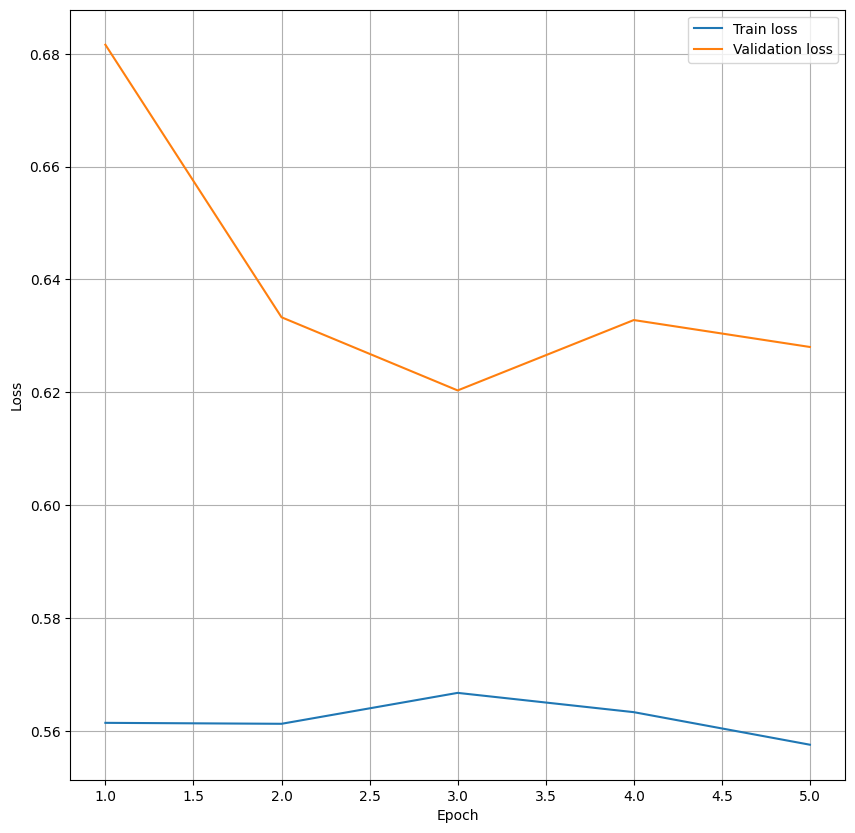

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(range(1, epochs + 1), train_losses, label = 'Train loss')
plt.plot(range(1, epochs + 1), validation_losses, label = 'Validation loss')

# plt.plot(range(1, 50 + 1), train_losses, label = 'Train loss')
# plt.plot(range(1, 50 + 1), validation_losses, label = 'Validation loss')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [ ]:
# import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './drive/MyDrive/HW8_BERT/bert_classifier.pth'

# # Create output directory if needed
# model.save_pretrained('./drive/MyDrive/HW8_BERT/sentiment_classifier', safe_serialization=False)
# tokenizer.save_pretrained('./drive/MyDrive/HW8_BERT/sentiment_classifier')

#### Тестирование и оценка модели

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Предсказание на тестовом наборе
model.eval()

# Переменные для отслеживания предсказаний и истинных меток
predictions, true_labels, predicted_logits = [], [], []

# Предсказание
for batch in test_loader:
    input_ids = batch['input_ids'].squeeze(1).to(device)
    attention_mask = batch['attention_mask'].squeeze(1).to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        # Прямой проход, получаем логиты
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs.logits

    # Переводим логиты в предсказания (выбираем класс с наибольшим логитом)
    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)

    # Переносим метки на CPU
    logits = logits.to('cpu').numpy()
    labels = labels.to('cpu').numpy()

    # Сохраняем предсказания и истинные метки
    predictions.extend(preds)
    true_labels.extend(labels)
    predicted_logits.extend(logits)

ai-forever/ruBert-base Accuracy: 0.75
ai-forever/ruBert-base Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.05      0.09       243
           1       0.75      0.99      0.86       717

    accuracy                           0.75       960
   macro avg       0.71      0.52      0.47       960
weighted avg       0.73      0.75      0.66       960



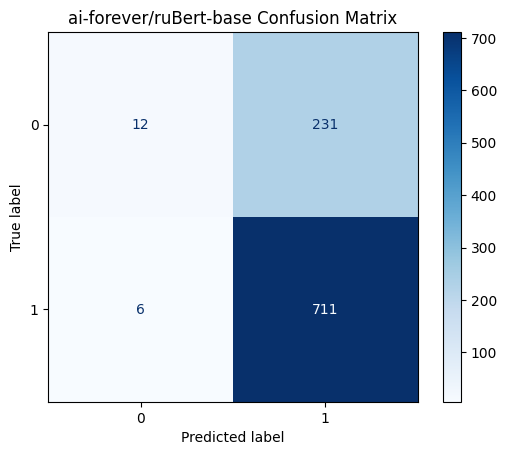

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions)

    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

evaluate_model(true_labels, predictions)

Видим, что модель обучилась плохо классифицировать ошибки в пердложениях (recall  всего 5 процентов).

Это связано с несбалансированным набором данных.

In [ ]:
test_data['acceptable'].value_counts()

,count
acceptable,
1,733
0,250


In [ ]:
len(np.where(predictions == 1)[0])

<ipython-input-50-2eca2209455a>:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  len(np.where(predictions == 1)[0])


0

In [ ]:
# predictions

In [ ]:
def classify(text):
    with torch.no_grad():
        proba = torch.argmax(model(**tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)).logits, -1)
    return proba.cpu().numpy()[0]

In [ ]:
classify('Я памагал друзьям')

1

In [ ]:
classify('Этим летом не никуда ездили.')

1

In [ ]:
classify('Мне было весело')

1

### Часть 2. Few-/zero-shot RuGPT3 base

Few-shot и zero-shot — это методы, используемые в области машинного обучения, особенно для задач обработки естественного языка (NLP), когда модель не обучена на конкретных примерах, а лишь использует небольшой набор примеров (few-shot) или вовсе не использует примеров (zero-shot) для выполнения задачи.

В качестве входных данных предоставляется текст, который нужно классифицировать.
Модель будет "понимать" задачу, потому что она обучена на большом наборе данных и может интерпретировать запрос в контексте предсказания наличия ошибок.


**Zero-shot**: Просто сформулируй задачу так, чтобы модель могла ее понять. Например, задавая вопросы о правильности предложений, или просто попросив классифицировать текст как правильный/неправильный.

**Few-shot**: Предоставь модели несколько примеров предложений с метками (правильное/неправильное), чтобы модель "научилась" распознавать ошибки.

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline(task = "zero-shot-classification",
                      model = "sberbank-ai/rugpt3large_based_on_gpt2")

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/rugpt3large_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Device set to use cuda:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


#### Zero-shot

In [ ]:
class ZeroShotDataset(Dataset):
    def __init__(self, sentences, candidate_labels):
        self.sentences = sentences
        self.candidate_labels = candidate_labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        # Применяем классификацию для предложения
        result = classifier(sentence, candidate_labels=self.candidate_labels)
        # Возвращаем индекс категории с максимальной вероятностью
        label = np.array(result['scores']).argmin()
        return label

In [ ]:
candidate_labels  = ['Правильно', 'Ошибочно']

# Создаем Dataset
dataset = ZeroShotDataset(sentences=test_data['sentence'], candidate_labels=candidate_labels)

In [ ]:
# Используем DataLoader для батчевой обработки
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
classifier('Я памагал друзьям', candidate_labels)

{'sequence': 'Я памагал друзьям',
 'labels': ['Правильно', 'Ошибочно'],
 'scores': [0.5629498958587646, 0.43705007433891296]}

In [ ]:
# test_data['zero-shot classification'] = test_data['sentence'].apply(lambda x: np.array(classifier(x, candidate_labels)['scores']).argmax())
# test_data.head()

In [ ]:
# Преобразуем результат в DataFrame
results = []
for labels in dataloader:
    results.extend(labels.numpy())

# Добавляем в исходный DataFrame
test_data['zero-shot classification'] = results

test_data.head()

,sentence,acceptable,zero-shot classification,few-shot classification 1 example,few-shot classification 2 exampleы
id,,,,,
0,Иван вчера не позвонил.,1,1,0,0
1,"У многих туристов, кто посещают Кемер весной, ...",0,1,0,0
2,Лесные запахи набегали волнами; в них смешалос...,1,1,0,0
3,Вчера президент имел неофициальную беседу с ан...,1,1,0,0
4,Коллега так и не признал вину за катастрофу пе...,1,1,0,0


In [ ]:
test_data['zero-shot classification'].value_counts()

,count
zero-shot classification,
1,983


#### Few-shot

In [ ]:
class FewShotDataset(Dataset):
    def __init__(self, sentences, candidate_labels, few_shot_examples):
        self.sentences = sentences
        self.candidate_labels = candidate_labels
        self.few_shot_examples = few_shot_examples

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        # Применяем классификацию для предложения
        result = classifier( self.few_shot_examples + f"\nТеперь, классифицируйте это предложение: {sentence}",
                            candidate_labels=self.candidate_labels)

        # Возвращаем индекс категории с максимальной вероятностью
        label = np.array(result['scores']).argmin()
        return label

In [ ]:
few_shot_examples_1 = """Пример 1: "А ты ехай прямо к директору театров, князю Гагарину." -> Ошибочное"""

few_shot_examples_2 = """
Пример 1: "А ты ехай прямо к директору театров, князю Гагарину." -> Ошибочное
Пример 2: "Он часто ходит на прогулку вечером." -> Правильное
"""

few_shot_examples_4 = """
Пример 1: "А ты ехай прямо к директору театров, князю Гагарину." -> Ошибочное
Пример 2: "Он часто ходит на прогулку вечером." -> Правильное
Пример 3: "Вчера в два часа магазин закрыт." -> Ошибочное
Пример 4: "Она всегда была добра и отзывчива." -> Правильное
"""

In [ ]:
candidate_labels  = ['Правильно', 'Ошибочно']

##### Few-shot 1 пример

In [ ]:
# Создаем Dataset
dataset = FewShotDataset(sentences=test_data['sentence'],
                           candidate_labels=candidate_labels,
                           few_shot_examples = few_shot_examples_1)

# Используем DataLoader для батчевой обработки
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
# Преобразуем результат в DataFrame
results = []
for labels in dataloader:
    results.extend(labels.numpy())

# Добавляем в исходный DataFrame
test_data['few-shot classification 1 example'] = results

test_data.head()

,sentence,acceptable,zero-shot classification,few-shot classification 1 example,few-shot classification 2 exampleы
id,,,,,
0,Иван вчера не позвонил.,1,1,1,0
1,"У многих туристов, кто посещают Кемер весной, ...",0,1,1,0
2,Лесные запахи набегали волнами; в них смешалос...,1,1,1,0
3,Вчера президент имел неофициальную беседу с ан...,1,1,1,0
4,Коллега так и не признал вину за катастрофу пе...,1,1,1,0


In [ ]:
test_data['few-shot classification 1 example'].value_counts()

,count
few-shot classification 1 example,
1,983


##### Few-shot 2 примера

In [ ]:
# Создаем Dataset
dataset = FewShotDataset(sentences=test_data['sentence'],
                           candidate_labels=candidate_labels,
                           few_shot_examples = few_shot_examples_2)

# Используем DataLoader для батчевой обработки
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
# Преобразуем результат в DataFrame
results = []
for labels in dataloader:
    results.extend(labels.numpy())

# Добавляем в исходный DataFrame
test_data['few-shot classification 2 example'] = results

test_data.head()

,sentence,acceptable,zero-shot classification,few-shot classification 1 example,few-shot classification 2 exampleы
id,,,,,
0,Иван вчера не позвонил.,1,1,1,1
1,"У многих туристов, кто посещают Кемер весной, ...",0,1,1,1
2,Лесные запахи набегали волнами; в них смешалос...,1,1,1,1
3,Вчера президент имел неофициальную беседу с ан...,1,1,1,1
4,Коллега так и не признал вину за катастрофу пе...,1,1,1,1


In [ ]:
test_data['few-shot classification 2 exampleы'].value_counts()

,count
few-shot classification 2 exampleы,
1,983


##### Few-shot 4 примера

In [ ]:
# Создаем Dataset
dataset = FewShotDataset(sentences=test_data['sentence'],
                           candidate_labels=candidate_labels,
                           few_shot_examples = few_shot_examples_4)

# Используем DataLoader для батчевой обработки
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
# Преобразуем результат в DataFrame
results = []
for labels in dataloader:
    results.extend(labels.numpy())

# Добавляем в исходный DataFrame
test_data['few-shot classification 4 examples'] = results

test_data.head()

,sentence,acceptable,zero-shot classification,few-shot classification 1 example,few-shot classification 2 exampleы,few-shot classification 4 examples
id,,,,,,
0,Иван вчера не позвонил.,1,1,1,1,1
1,"У многих туристов, кто посещают Кемер весной, ...",0,1,1,1,1
2,Лесные запахи набегали волнами; в них смешалос...,1,1,1,1,1
3,Вчера президент имел неофициальную беседу с ан...,1,1,1,1,1
4,Коллега так и не признал вину за катастрофу пе...,1,1,1,1,1


In [ ]:
test_data['few-shot classification 4 examples'].value_counts()

,count
few-shot classification 4 examples,
1,983


#### Zero/Few-shot плохо сработали для данной задачи

### Часть 3. Fine tune RuT5

In [ ]:
!pip install datasets==2.21.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.
torch 2.5.1

In [ ]:
# !pip install evaluate

In [ ]:
!pip install razdel

In [ ]:
!python /content/RuCoLA/baselines/finetune_t5.py --model-name t5-base

2025-02-14 16:06:28.119703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739549188.139604    3443 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739549188.145784    3443 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 16:06:28.165751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/content/RuCoLA/baselines/finetune_t5.py:19: FutureWarning: load_metric is deprecated and will be removed in the next major v